In [1]:
# ============================================================================
# LECTURA COMPLETA DE TIFF GRANDE - OPTIMIZADA POR BLOQUES
# Para calcular estadísticas de TODO el archivo sin saturar RAM
# ============================================================================

# %% [markdown]
# ## Lectura y Análisis Completo del TIFF
# 
# Este notebook lee TODO el archivo por bloques para calcular estadísticas precisas

# %%
import numpy as np
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import gc  # Garbage collector para liberar memoria

plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.dpi'] = 100

# %% [markdown]
# ## 1. Inspección inicial del archivo

# %%
ruta_tiff = "../data/01_raw/AmeMM_100k.tif"

with rasterio.open(ruta_tiff) as src:
    print("=" * 70)
    print("📊 INFORMACIÓN DEL ARCHIVO")
    print("=" * 70)
    
    width = src.width
    height = src.height
    nodata = src.nodata
    dtype = src.dtypes[0]
    
    print(f"\n📄 Archivo: AmeMM_100k.tif")
    print(f"📐 Dimensiones: {width:,} x {height:,} píxeles")
    print(f"📊 Tipo de dato: {dtype}")
    print(f"🔢 Valor NoData: {nodata}")
    print(f"🌍 CRS: {src.crs}")
    print(f"📏 Resolución: {src.res}")
    
    # Calcular tamaño
    tamano_mb = (width * height * np.dtype(dtype).itemsize) / (1024 * 1024)
    tamano_gb = tamano_mb / 1024
    
    print(f"\n💾 Tamaño estimado:")
    print(f"   En RAM: {tamano_mb:.2f} MB ({tamano_gb:.2f} GB)")
    
    bounds = src.bounds
    print(f"\n📍 Límites geográficos:")
    print(f"   Norte: {bounds.top:.4f}°")
    print(f"   Sur:   {bounds.bottom:.4f}°")
    print(f"   Este:  {bounds.right:.4f}°")
    print(f"   Oeste: {bounds.left:.4f}°")

📊 INFORMACIÓN DEL ARCHIVO

📄 Archivo: AmeMM_100k.tif
📐 Dimensiones: 43,811 x 59,851 píxeles
📊 Tipo de dato: uint32
🔢 Valor NoData: 2147483647.0
🌍 CRS: PROJCS["MAGNA_Transverse_Mercator",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6686"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4686"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4.59620041666667],PARAMETER["central_meridian",-74.0775079166667],PARAMETER["scale_factor",1],PARAMETER["false_easting",1000000],PARAMETER["false_northing",1000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
📏 Resolución: (30.864586362558, 30.864586362558)

💾 Tamaño estimado:
   En RAM: 10002.64 MB (9.77 GB)

📍 Límites geográficos:
   Norte: 1871234.6213°
   Sur:   23958.2629°
   Este:  1803779.5814°
   Oeste: 451571.1883°


In [2]:
# %% [markdown]
# ## 2. Calcular estadísticas leyendo TODO el archivo por bloques
# 
# Esta celda lee el archivo completo en bloques pequeños para no saturar la RAM.
# Puede tomar 1-5 minutos dependiendo del tamaño del archivo.

# %%
def calcular_estadisticas_completas(ruta, tamano_bloque=2048):
    """
    Calcula estadísticas de TODO el raster leyendo por bloques.
    Retorna estadísticas precisas sin cargar todo en memoria.
    """
    print("🔄 Leyendo archivo completo por bloques...")
    print(f"   Tamaño de bloque: {tamano_bloque}x{tamano_bloque} píxeles\n")
    
    with rasterio.open(ruta) as src:
        nodata = src.nodata
        
        # Listas para acumular valores
        todos_valores = []
        
        # Calcular número de bloques
        n_bloques_x = (src.width + tamano_bloque - 1) // tamano_bloque
        n_bloques_y = (src.height + tamano_bloque - 1) // tamano_bloque
        total_bloques = n_bloques_x * n_bloques_y
        
        print(f"📦 Total de bloques a procesar: {total_bloques}")
        print(f"📊 Esto puede tomar 1-5 minutos dependiendo del tamaño...\n")
        
        # Usar tqdm para barra de progreso
        with tqdm(total=total_bloques, desc="Procesando", unit="bloque") as pbar:
            for j in range(0, src.height, tamano_bloque):
                for i in range(0, src.width, tamano_bloque):
                    # Calcular tamaño del bloque actual
                    h = min(tamano_bloque, src.height - j)
                    w = min(tamano_bloque, src.width - i)
                    
                    # Crear ventana
                    window = Window(i, j, w, h)
                    
                    # Leer bloque
                    data = src.read(1, window=window)
                    
                    # Filtrar NoData y agregar valores
                    if nodata is not None:
                        valores_validos = data[data != nodata]
                    else:
                        valores_validos = data.flatten()
                    
                    if len(valores_validos) > 0:
                        todos_valores.append(valores_validos)
                    
                    pbar.update(1)
                    
                    # Liberar memoria cada 100 bloques
                    if len(todos_valores) > 100:
                        todos_valores = [np.concatenate(todos_valores)]
                        gc.collect()
        
        # Concatenar todos los valores
        print("\n🔄 Consolidando resultados...")
        if len(todos_valores) > 1:
            valores_finales = np.concatenate(todos_valores)
        else:
            valores_finales = todos_valores[0]
        
        print(f"✅ Procesamiento completado!")
        print(f"📊 Total de píxeles válidos: {len(valores_finales):,}\n")
        
        return valores_finales, nodata

# Ejecutar cálculo completo
valores_completos, nodata_value = calcular_estadisticas_completas(ruta_tiff, tamano_bloque=2048)

🔄 Leyendo archivo completo por bloques...
   Tamaño de bloque: 2048x2048 píxeles

📦 Total de bloques a procesar: 660
📊 Esto puede tomar 1-5 minutos dependiendo del tamaño...



Procesando:   0%|          | 0/660 [00:00<?, ?bloque/s]


🔄 Consolidando resultados...
✅ Procesamiento completado!
📊 Total de píxeles válidos: 2,622,132,161



In [3]:
# %% [markdown]
# ## 3. Estadísticas del archivo COMPLETO

# %%
print("=" * 70)
print("📈 ESTADÍSTICAS COMPLETAS DEL ARCHIVO")
print("=" * 70)

print(f"\n📊 Píxeles analizados: {len(valores_completos):,}")
print(f"\n📉 Estadísticas básicas:")
print(f"   Mínimo:       {valores_completos.min():.4f}")
print(f"   Máximo:       {valores_completos.max():.4f}")
print(f"   Media:        {valores_completos.mean():.4f}")
print(f"   Mediana:      {np.median(valores_completos):.4f}")
print(f"   Desv. Est.:   {valores_completos.std():.4f}")

# Calcular percentiles detallados
percentiles = [10, 20, 25, 33, 40, 50, 60, 66, 75, 80, 90, 95, 99]
valores_percentiles = np.percentile(valores_completos, percentiles)

print(f"\n📊 Percentiles:")
for p, v in zip(percentiles, valores_percentiles):
    print(f"   P{p:2d}: {v:8.4f}")

# Calcular umbrales para 3 categorías
umbral_bajo = np.percentile(valores_completos, 33)
umbral_alto = np.percentile(valores_completos, 66)

print("\n" + "=" * 70)
print("🎯 UMBRALES PARA CLASIFICACIÓN EN 3 NIVELES")
print("=" * 70)
print(f"\n🟢 AMENAZA BAJA:  Valores ≤ {umbral_bajo:.4f}")
print(f"🟡 AMENAZA MEDIA: Valores > {umbral_bajo:.4f} y ≤ {umbral_alto:.4f}")
print(f"🔴 AMENAZA ALTA:  Valores > {umbral_alto:.4f}")

# Calcular distribución por categorías
n_baja = np.sum(valores_completos <= umbral_bajo)
n_media = np.sum((valores_completos > umbral_bajo) & (valores_completos <= umbral_alto))
n_alta = np.sum(valores_completos > umbral_alto)
total = len(valores_completos)

print(f"\n📊 Distribución de píxeles:")
print(f"   🟢 Baja:  {n_baja:,} ({n_baja/total*100:.1f}%)")
print(f"   🟡 Media: {n_media:,} ({n_media/total*100:.1f}%)")
print(f"   🔴 Alta:  {n_alta:,} ({n_alta/total*100:.1f}%)")

📈 ESTADÍSTICAS COMPLETAS DEL ARCHIVO

📊 Píxeles analizados: 2,622,132,161

📉 Estadísticas básicas:
   Mínimo:       0.0000
   Máximo:       15230.0000
   Media:        1603.6653
   Mediana:      0.0000
   Desv. Est.:   3603.4243

📊 Percentiles:
   P10:   0.0000
   P20:   0.0000
   P25:   0.0000
   P33:   0.0000
   P40:   0.0000
   P50:   0.0000
   P60:  94.0000
   P66: 349.0000
   P75: 542.0000
   P80: 1296.0000
   P90: 7189.0000
   P95: 12071.0000
   P99: 14220.0000

🎯 UMBRALES PARA CLASIFICACIÓN EN 3 NIVELES

🟢 AMENAZA BAJA:  Valores ≤ 0.0000
🟡 AMENAZA MEDIA: Valores > 0.0000 y ≤ 349.0000
🔴 AMENAZA ALTA:  Valores > 349.0000

📊 Distribución de píxeles:
   🟢 Baja:  1,433,286,057 (54.7%)
   🟡 Media: 297,750,172 (11.4%)
   🔴 Alta:  891,095,932 (34.0%)


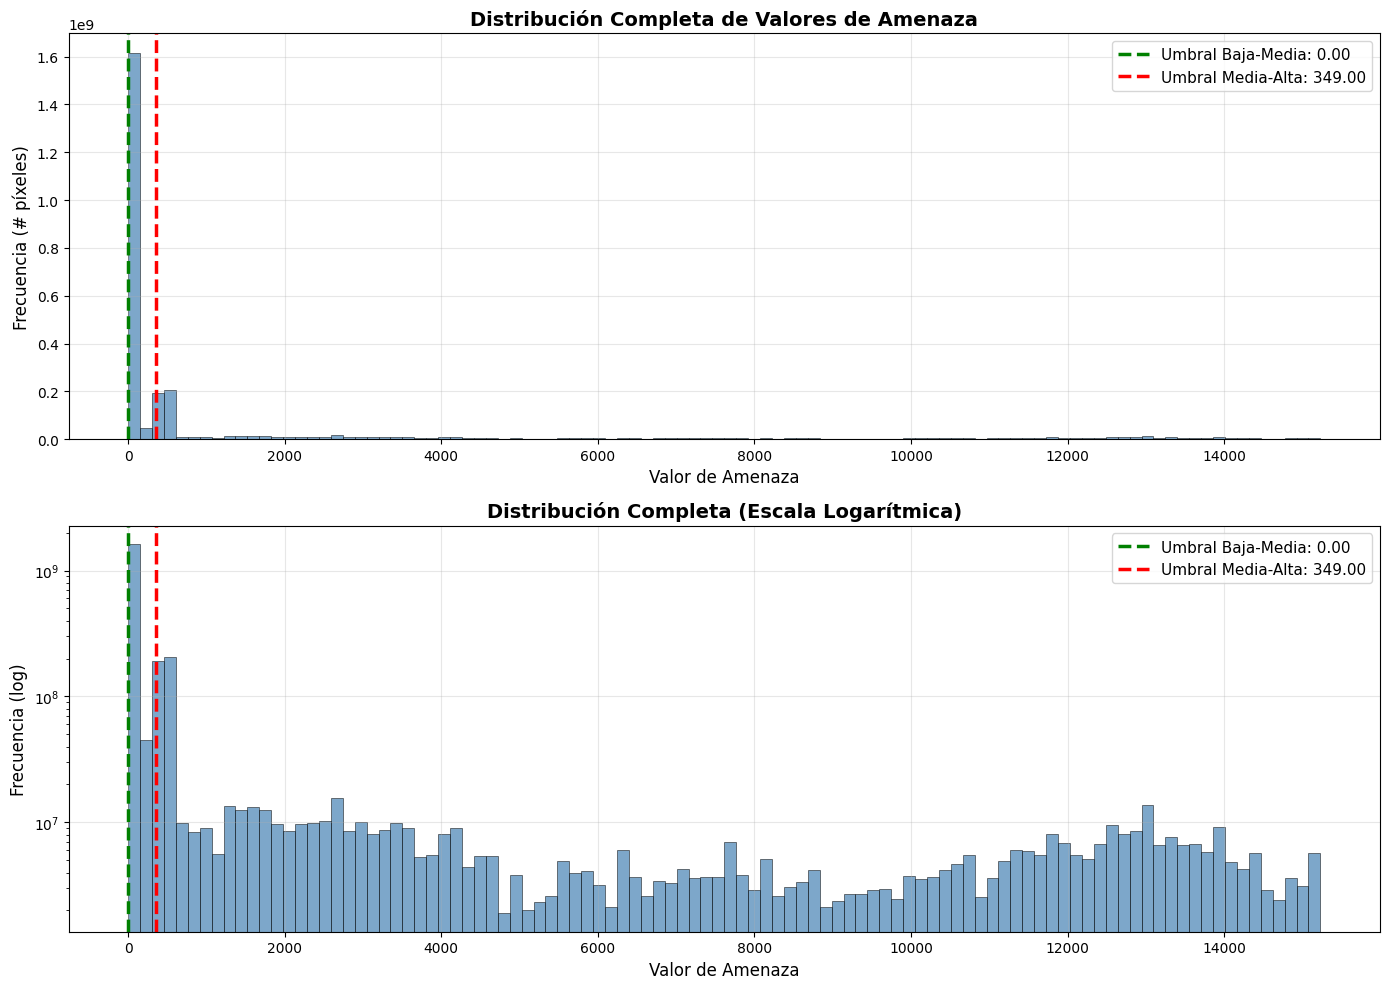

💾 Gráfico guardado: distribucion_completa_amenaza.png


In [4]:
# %% [markdown]
# ## 4. Visualización de la distribución COMPLETA

# %%
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Histograma completo
axes[0].hist(valores_completos, bins=100, color='steelblue', 
             edgecolor='black', alpha=0.7, linewidth=0.5)
axes[0].axvline(umbral_bajo, color='green', linestyle='--', linewidth=2.5, 
                label=f'Umbral Baja-Media: {umbral_bajo:.2f}')
axes[0].axvline(umbral_alto, color='red', linestyle='--', linewidth=2.5, 
                label=f'Umbral Media-Alta: {umbral_alto:.2f}')
axes[0].set_title('Distribución Completa de Valores de Amenaza', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Valor de Amenaza', fontsize=12)
axes[0].set_ylabel('Frecuencia (# píxeles)', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Histograma con escala logarítmica (para ver mejor la distribución)
axes[1].hist(valores_completos, bins=100, color='steelblue', 
             edgecolor='black', alpha=0.7, linewidth=0.5)
axes[1].axvline(umbral_bajo, color='green', linestyle='--', linewidth=2.5, 
                label=f'Umbral Baja-Media: {umbral_bajo:.2f}')
axes[1].axvline(umbral_alto, color='red', linestyle='--', linewidth=2.5, 
                label=f'Umbral Media-Alta: {umbral_alto:.2f}')
axes[1].set_yscale('log')
axes[1].set_title('Distribución Completa (Escala Logarítmica)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Valor de Amenaza', fontsize=12)
axes[1].set_ylabel('Frecuencia (log)', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('distribucion_completa_amenaza.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Gráfico guardado: distribucion_completa_amenaza.png")

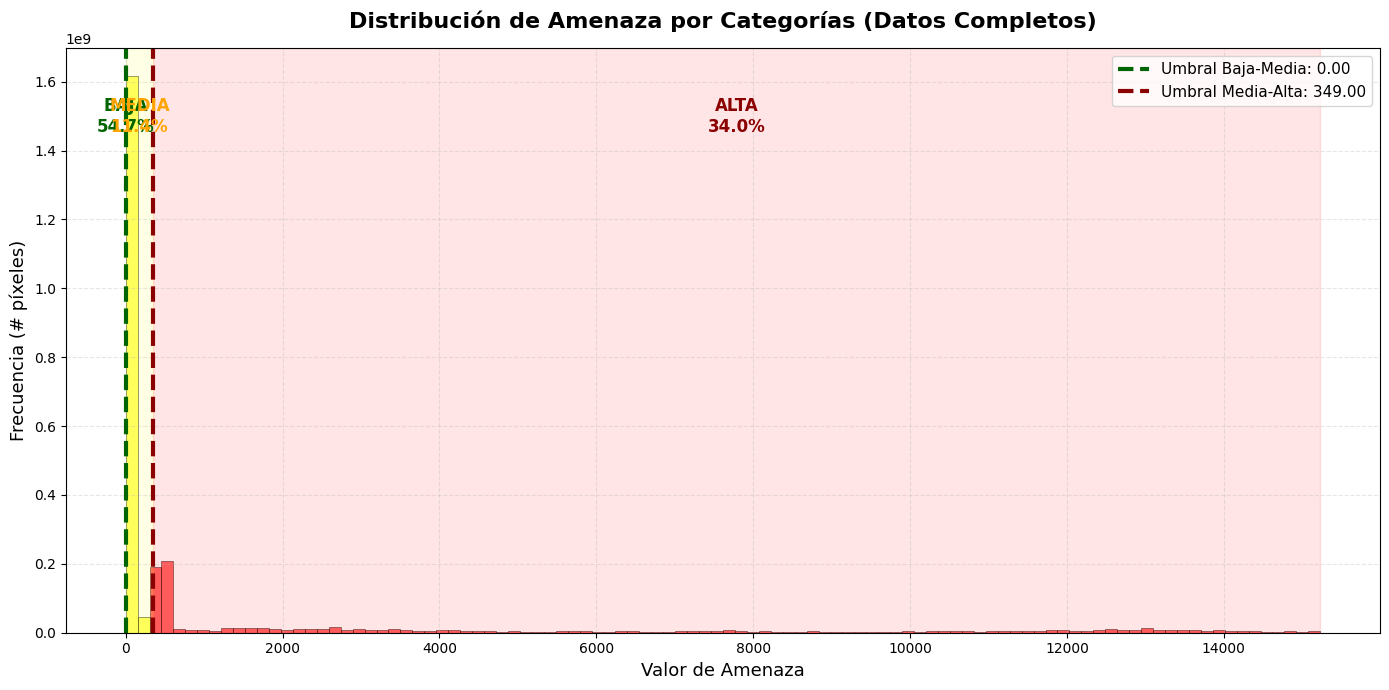

💾 Gráfico guardado: distribucion_categorias_amenaza.png


In [5]:
# %% [markdown]
# ## 5. Visualización con zonas coloreadas

# %%
plt.figure(figsize=(14, 7))

# Histograma
n, bins, patches = plt.hist(valores_completos, bins=100, color='lightgray', 
                            edgecolor='black', alpha=0.7, linewidth=0.5)

# Colorear barras según categoría
for i, patch in enumerate(patches):
    bin_center = (bins[i] + bins[i+1]) / 2
    if bin_center <= umbral_bajo:
        patch.set_facecolor('green')
        patch.set_alpha(0.6)
    elif bin_center <= umbral_alto:
        patch.set_facecolor('yellow')
        patch.set_alpha(0.6)
    else:
        patch.set_facecolor('red')
        patch.set_alpha(0.6)

# Líneas de umbrales
plt.axvline(umbral_bajo, color='darkgreen', linestyle='--', linewidth=3, 
            label=f'Umbral Baja-Media: {umbral_bajo:.2f}')
plt.axvline(umbral_alto, color='darkred', linestyle='--', linewidth=3, 
            label=f'Umbral Media-Alta: {umbral_alto:.2f}')

# Áreas sombreadas
plt.axvspan(valores_completos.min(), umbral_bajo, alpha=0.1, color='green')
plt.axvspan(umbral_bajo, umbral_alto, alpha=0.1, color='yellow')
plt.axvspan(umbral_alto, valores_completos.max(), alpha=0.1, color='red')

plt.title('Distribución de Amenaza por Categorías (Datos Completos)', 
          fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Valor de Amenaza', fontsize=13)
plt.ylabel('Frecuencia (# píxeles)', fontsize=13)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3, linestyle='--')

# Agregar texto con porcentajes
y_max = n.max()
plt.text(umbral_bajo/2, y_max*0.9, f'BAJA\n{n_baja/total*100:.1f}%', 
         ha='center', fontsize=12, fontweight='bold', color='darkgreen')
plt.text((umbral_bajo + umbral_alto)/2, y_max*0.9, f'MEDIA\n{n_media/total*100:.1f}%', 
         ha='center', fontsize=12, fontweight='bold', color='orange')
plt.text((umbral_alto + valores_completos.max())/2, y_max*0.9, f'ALTA\n{n_alta/total*100:.1f}%', 
         ha='center', fontsize=12, fontweight='bold', color='darkred')

plt.tight_layout()
plt.savefig('distribucion_categorias_amenaza.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Gráfico guardado: distribucion_categorias_amenaza.png")

/var/folders/8p/q51pz9mn38d4_725jygnhwhh0000gn/T/ipykernel_14050/1191334526.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/8p/q51pz9mn38d4_725jygnhwhh0000gn/T/ipykernel_14050/1191334526.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('boxplot_amenaza.png', dpi=150, bbox_inches='tight')
/Users/feliperuizzea/Documents/3.Proyectos_programacion/isa-geospatial-alerts/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


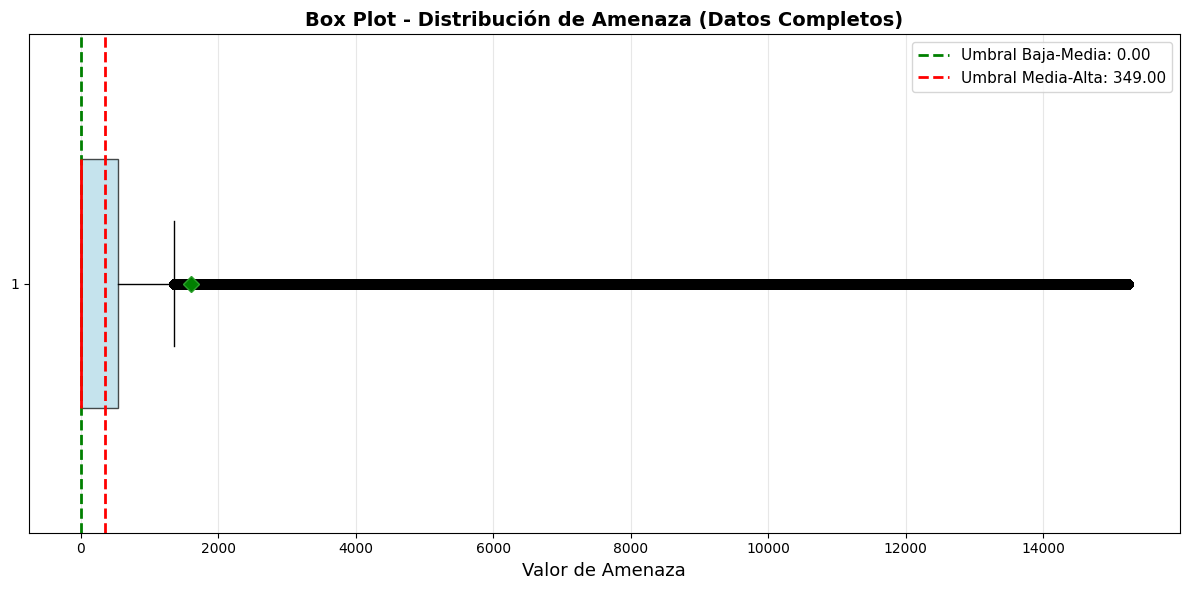

💾 Gráfico guardado: boxplot_amenaza.png


In [6]:
# %% [markdown]
# ## 6. Box plot para visualizar outliers

# %%
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

bp = ax.boxplot([valores_completos], vert=False, widths=0.5, 
                 patch_artist=True, showmeans=True,
                 boxprops=dict(facecolor='lightblue', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2),
                 meanprops=dict(marker='D', markerfacecolor='green', markersize=8))

# Agregar líneas de umbrales
ax.axvline(umbral_bajo, color='green', linestyle='--', linewidth=2, 
           label=f'Umbral Baja-Media: {umbral_bajo:.2f}')
ax.axvline(umbral_alto, color='red', linestyle='--', linewidth=2, 
           label=f'Umbral Media-Alta: {umbral_alto:.2f}')

ax.set_xlabel('Valor de Amenaza', fontsize=13)
ax.set_title('Box Plot - Distribución de Amenaza (Datos Completos)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('boxplot_amenaza.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Gráfico guardado: boxplot_amenaza.png")

In [7]:
# %% [markdown]
# ## 7. AHORA SÍ: Clasificar TODO el archivo usando los umbrales calculados

# %%
def clasificar_tiff_completo(ruta_in, ruta_out, umbral_bajo, umbral_alto, 
                             tamano_bloque=2048, comprimir=True):
    """
    Clasifica el TIFF completo en 3 niveles, procesando por bloques.
    """
    print("=" * 70)
    print("🔄 CLASIFICANDO ARCHIVO COMPLETO")
    print("=" * 70)
    
    print(f"\n⚙️  Configuración:")
    print(f"   Tamaño de bloque: {tamano_bloque}x{tamano_bloque}")
    print(f"   Umbral Baja-Media: {umbral_bajo:.4f}")
    print(f"   Umbral Media-Alta: {umbral_alto:.4f}")
    print(f"   Compresión: {'Sí (LZW)' if comprimir else 'No'}")
    
    with rasterio.open(ruta_in) as src:
        nodata = src.nodata
        
        # Preparar perfil para archivo de salida
        profile = src.profile.copy()
        profile.update({
            'dtype': rasterio.uint8,
            'nodata': 0,
            'driver': 'GTiff'
        })
        
        if comprimir:
            profile['compress'] = 'lzw'
        
        # Calcular bloques
        n_bloques_x = (src.width + tamano_bloque - 1) // tamano_bloque
        n_bloques_y = (src.height + tamano_bloque - 1) // tamano_bloque
        total_bloques = n_bloques_x * n_bloques_y
        
        print(f"\n📦 Total de bloques: {total_bloques}")
        print(f"\n🔄 Procesando...\n")
        
        with rasterio.open(ruta_out, 'w', **profile) as dst:
            with tqdm(total=total_bloques, desc="Clasificando", unit="bloque") as pbar:
                for j in range(0, src.height, tamano_bloque):
                    for i in range(0, src.width, tamano_bloque):
                        # Calcular dimensiones del bloque
                        h = min(tamano_bloque, src.height - j)
                        w = min(tamano_bloque, src.width - i)
                        
                        window = Window(i, j, w, h)
                        
                        # Leer bloque
                        data = src.read(1, window=window)
                        
                        # Clasificar
                        classified = np.zeros(data.shape, dtype=np.uint8)
                        
                        if nodata is not None:
                            mask_validos = data != nodata
                            classified[mask_validos & (data <= umbral_bajo)] = 1  # Baja
                            classified[mask_validos & (data > umbral_bajo) & (data <= umbral_alto)] = 2  # Media
                            classified[mask_validos & (data > umbral_alto)] = 3  # Alta
                        else:
                            classified[data <= umbral_bajo] = 1
                            classified[(data > umbral_bajo) & (data <= umbral_alto)] = 2
                            classified[data > umbral_alto] = 3
                        
                        # Escribir bloque clasificado
                        dst.write(classified, 1, window=window)
                        
                        pbar.update(1)
    
    print(f"\n✅ Archivo clasificado guardado en:")
    print(f"   {ruta_out}")
    
    # Verificar tamaño del archivo
    import os
    tamano_mb = os.path.getsize(ruta_out) / (1024 * 1024)
    print(f"\n📊 Tamaño del archivo: {tamano_mb:.2f} MB")

# Ejecutar clasificación completa
ruta_salida = "../data/02_processed/AmeMM_100k_clasificado.tif"

clasificar_tiff_completo(
    ruta_tiff, 
    ruta_salida, 
    umbral_bajo, 
    umbral_alto, 
    tamano_bloque=2048,
    comprimir=True
)

print("\n🎉 ¡Clasificación completa!")

🔄 CLASIFICANDO ARCHIVO COMPLETO

⚙️  Configuración:
   Tamaño de bloque: 2048x2048
   Umbral Baja-Media: 0.0000
   Umbral Media-Alta: 349.0000
   Compresión: Sí (LZW)

📦 Total de bloques: 660

🔄 Procesando...



Clasificando:   0%|          | 0/660 [00:00<?, ?bloque/s]


✅ Archivo clasificado guardado en:
   ../data/02_processed/AmeMM_100k_clasificado.tif

📊 Tamaño del archivo: 33.53 MB

🎉 ¡Clasificación completa!


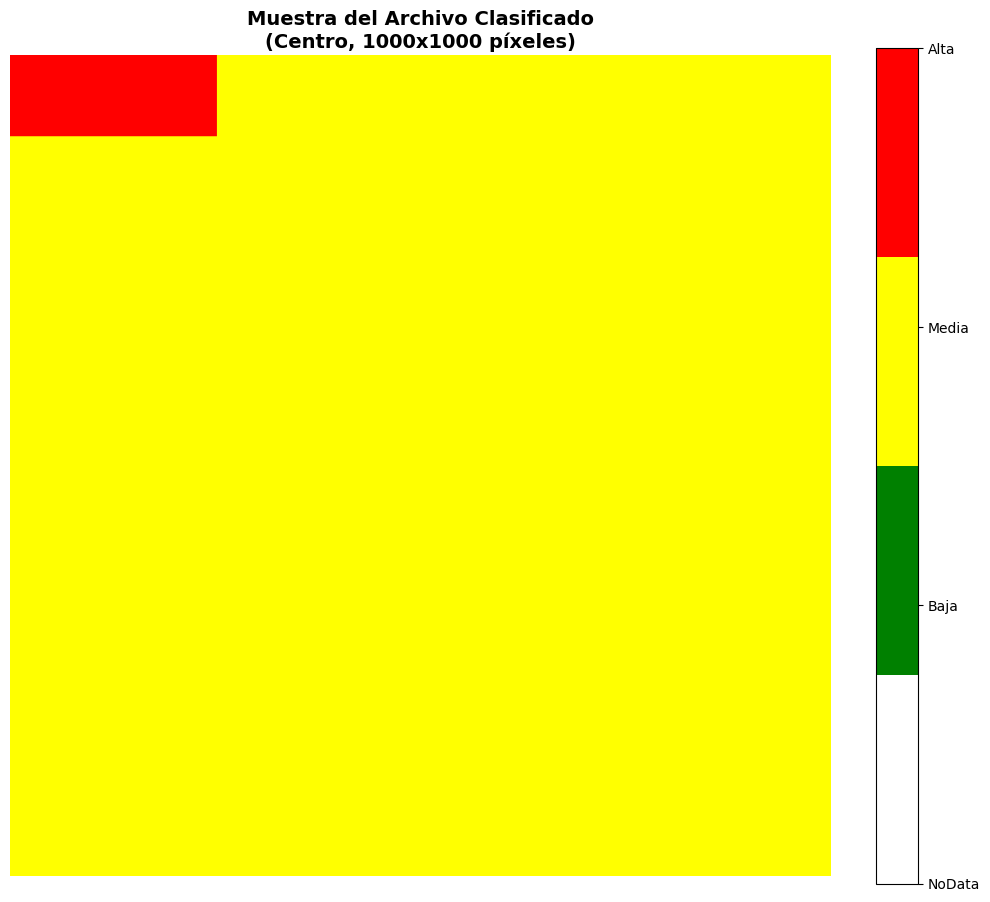


📊 Distribución en la muestra:
   Media: 975,052 píxeles
   Alta: 24,948 píxeles


In [8]:
# %% [markdown]
# ## 8. Verificar el archivo clasificado

# %%
# Leer muestra del archivo clasificado para verificar
with rasterio.open(ruta_salida) as src:
    # Leer muestra del centro
    centro_x = src.width // 2
    centro_y = src.height // 2
    window = Window(centro_x - 500, centro_y - 500, 1000, 1000)
    muestra_clasificada = src.read(1, window=window)

# Visualizar
from matplotlib.colors import ListedColormap

colors = ['white', 'green', 'yellow', 'red']
cmap = ListedColormap(colors)

plt.figure(figsize=(10, 10))
im = plt.imshow(muestra_clasificada, cmap=cmap, vmin=0, vmax=3)
plt.title('Muestra del Archivo Clasificado\n(Centro, 1000x1000 píxeles)', 
          fontsize=14, fontweight='bold')
plt.axis('off')
cbar = plt.colorbar(im, ticks=[0, 1, 2, 3], fraction=0.046)
cbar.ax.set_yticklabels(['NoData', 'Baja', 'Media', 'Alta'])
plt.tight_layout()
plt.show()

# Contar valores
unique, counts = np.unique(muestra_clasificada, return_counts=True)
print("\n📊 Distribución en la muestra:")
for val, count in zip(unique, counts):
    nivel = {0: 'NoData', 1: 'Baja', 2: 'Media', 3: 'Alta'}
    print(f"   {nivel.get(val, 'Desconocido')}: {count:,} píxeles")

In [9]:
# %% [markdown]
# ## 9. Resumen final

# %%
print("\n" + "=" * 70)
print("✅ PROCESAMIENTO COMPLETO FINALIZADO")
print("=" * 70)

print(f"\n📁 Archivos generados:")
print(f"   1. {ruta_salida}")
print(f"   2. distribucion_completa_amenaza.png")
print(f"   3. distribucion_categorias_amenaza.png")
print(f"   4. boxplot_amenaza.png")

print(f"\n🎯 Umbrales calculados (datos completos):")
print(f"   🟢 Baja-Media: {umbral_bajo:.4f}")
print(f"   🔴 Media-Alta: {umbral_alto:.4f}")

print(f"\n📊 Estadísticas:")
print(f"   Total píxeles analizados: {len(valores_completos):,}")
print(f"   Baja:  {n_baja:,} ({n_baja/total*100:.1f}%)")
print(f"   Media: {n_media:,} ({n_media/total*100:.1f}%)")
print(f"   Alta:  {n_alta:,} ({n_alta/total*100:.1f}%)")

print(f"\n🚀 SIGUIENTE PASO:")
print(f"   Usa el archivo clasificado para extraer valores en ubicaciones de torres")
print(f"   Archivo: {ruta_salida}")

# Liberar memoria
del valores_completos
gc.collect()

print("\n✅ Memoria liberada. Notebook listo para continuar.")


✅ PROCESAMIENTO COMPLETO FINALIZADO

📁 Archivos generados:
   1. ../data/02_processed/AmeMM_100k_clasificado.tif
   2. distribucion_completa_amenaza.png
   3. distribucion_categorias_amenaza.png
   4. boxplot_amenaza.png

🎯 Umbrales calculados (datos completos):
   🟢 Baja-Media: 0.0000
   🔴 Media-Alta: 349.0000

📊 Estadísticas:
   Total píxeles analizados: 2,622,132,161
   Baja:  1,433,286,057 (54.7%)
   Media: 297,750,172 (11.4%)
   Alta:  891,095,932 (34.0%)

🚀 SIGUIENTE PASO:
   Usa el archivo clasificado para extraer valores en ubicaciones de torres
   Archivo: ../data/02_processed/AmeMM_100k_clasificado.tif

✅ Memoria liberada. Notebook listo para continuar.
